In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3 # RGB
EPOCHS = 2

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [7]:
len(dataset)

68

68 batches of 32 images per batch

In [43]:
print(dataset.take(1))

<TakeDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>


(256, 256, 3)
32


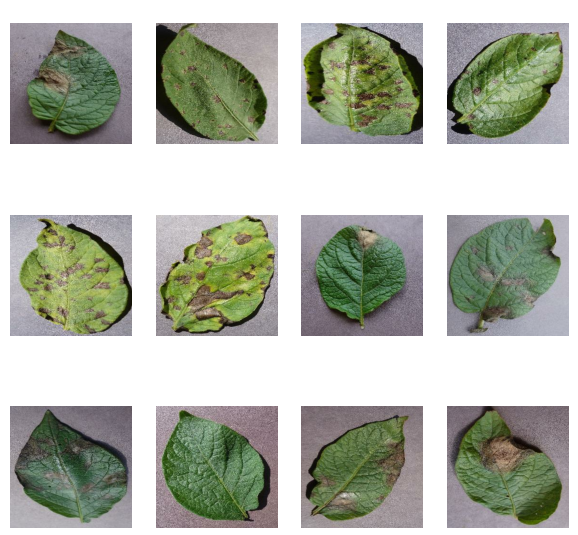

In [8]:
plt.figure(figsize=(10,10))

for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].shape)
    print(len(label_batch.numpy()))

    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]], color="white")
        plt.axis("off")


80 % ==> Training data

20 % ==> 10 % ==> Validation Data
         10 % ==> Test data

In [5]:
def get_dataset_partition(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    N = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    train_size = int(train_split * N)
    val_size = int(val_split * N)
    
    train_ds = dataset.take(train_size)
    val_ds = dataset.skip(train_size).take(val_size)
    test_ds = dataset.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [6]:
train_ds, val_ds, test_ds = get_dataset_partition(dataset)

In [11]:
len(train_ds), len(val_ds), len(test_ds)

(54, 6, 8)

In [7]:
train_ds = train_ds.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [14]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [15]:
n_classes = len(class_names)
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

In [16]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation="relu", input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(n_classes, activation="softmax")
])

model.build(input_shape=input_shape)

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)         

In [18]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [19]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/2
54/54 [==============================] - 214s 4s/step - loss: 0.8891 - accuracy: 0.5295 - val_loss: 0.9002 - val_accuracy: 0.4688
Epoch 2/2
54/54 [==============================] - 169s 3s/step - loss: 0.6554 - accuracy: 0.7159 - val_loss: 0.4820 - val_accuracy: 0.7917


In [20]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 24s 418ms/step - loss: 0.5248 - accuracy: 0.7888


In [21]:
history.history

{'loss': [0.889095664024353, 0.6554322242736816],
 'accuracy': [0.5295138955116272, 0.7158564925193787],
 'val_loss': [0.9002030491828918, 0.4820035994052887],
 'val_accuracy': [0.46875, 0.7916666865348816]}

In [28]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

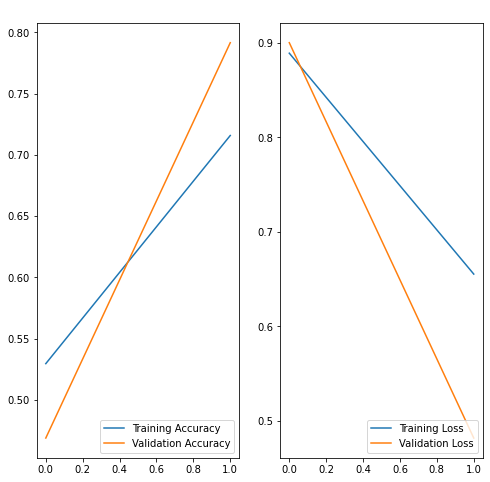

In [38]:
plt.figure(figsize=(8,8))

plt.subplot(1,2,1)
plt.plot(range(EPOCHS), accuracy, label="Training Accuracy")
plt.plot(range(EPOCHS), val_accuracy, label="Validation Accuracy")

plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy", color="white")

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label="Training Loss")
plt.plot(range(EPOCHS), val_loss, label="Validation Loss")

plt.legend(loc="lower right")
plt.title("Training and Validation Loss", color="white")

Actual:  Potato___Late_blight
Predicted:  Potato___Late_blight


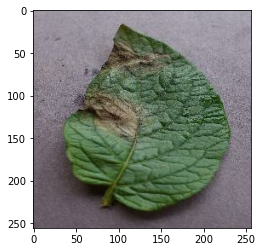

In [45]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    plt.imshow(first_image)
    print("Actual: ", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("Predicted: ", class_names[np.argmax(batch_prediction[0])])

In [12]:
model = tf.keras.models.load_model("../saved_models/model_1")

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    
    return predicted_class, confidence

In [18]:
for images, labels in test_ds.take(1):
    predicted, confidence = predict(model, images[0].numpy())
    print(confidence)

89.51


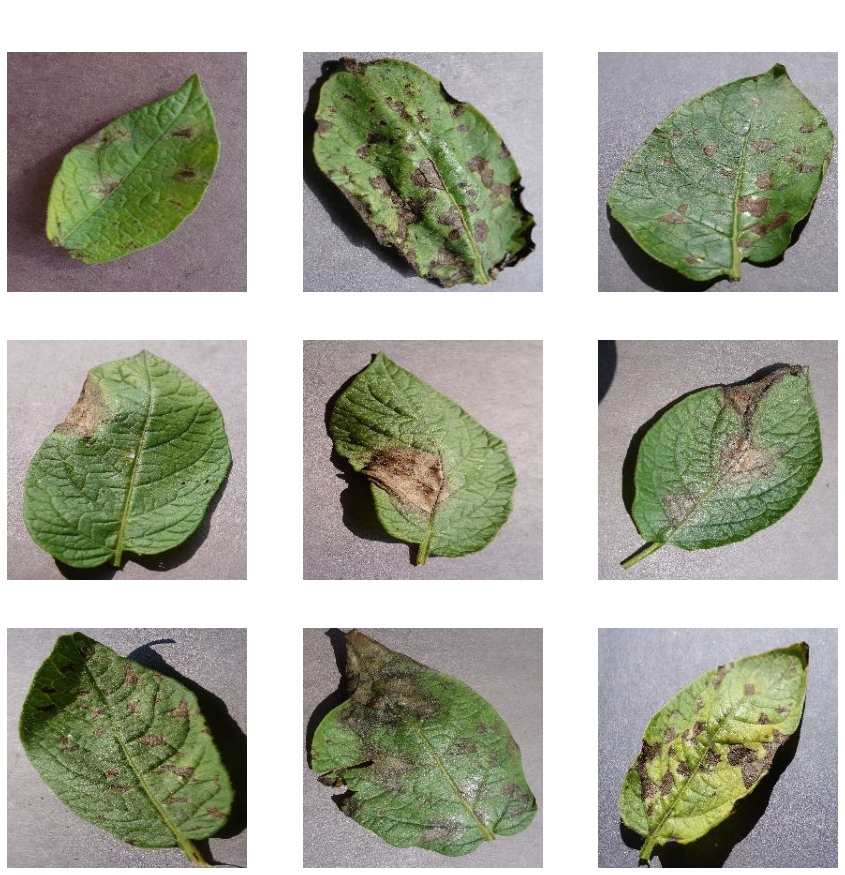

In [19]:
plt.figure(figsize=(15,15))

for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted, confidence = predict(model, images[i].numpy())
        actual = class_names[labels[i]]
        
        plt.title(f"Actual: {actual}\nPredicted: {predicted}\nConfidence: {confidence}%", color="white")
        
        plt.axis('off')

In [21]:
import os

In [31]:
model_version = len(os.listdir("../saved_models")) + 1
model.save(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/2/assets
